<a href="https://colab.research.google.com/github/kiril-buga/Neural-Network-Training-Project/blob/main/1D_CNN_Multilabel_V3/Y_Preprocessing_10sWindow_v03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECG Multi-Label Preprocessing
Fully independent notebook: loads raw data, processes, creates 5-class one-hot labels, uploads to HF

In [10]:
!pip install wfdb scikit-learn scipy matplotlib pandas numpy huggingface-hub h5py -q

import os
import json
import numpy as np
import pandas as pd
import wfdb
import h5py
from scipy.signal import resample
from datetime import datetime

np.random.seed(42)
print("Dependencies installed")

Dependencies installed


## Environment Setup

In [11]:
from huggingface_hub import snapshot_download
local_dir = snapshot_download(
      repo_id="kiril-buga/ECG-database",
      repo_type="dataset",
      allow_patterns="data/*",
      local_dir="/content/ECG-database/" # Specify the desired download directory
  )
print("Downloaded to:", local_dir)

DATA_PATH = f"{local_dir}/data/"
ARTIFACT_DIR = f"{local_dir}/artifacts/"

ECG_DIR = os.path.join(DATA_PATH, "Child_ecg/")
OUT_DIR = os.path.join(ARTIFACT_DIR, "multilabel_v6")
os.makedirs(OUT_DIR, exist_ok=True)

print(f"DATA: {DATA_PATH}")
print(f"OUTPUT: {OUT_DIR}")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Downloaded to: /content/ECG-database
DATA: /content/ECG-database/data/
OUTPUT: /content/ECG-database/artifacts/multilabel_v6


In [12]:
!cd $DATA_PATH && 7z x Child_ecg.zip
print("✓ Extraction complete!")


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1908237306 bytes (1820 MiB)

Extracting archive: Child_ecg.zip
 10% 4096 Open              --
Path = Child_ecg.zip
Type = zip
Physical Size = 1908237306
Embedded Stub Size = 4
Total Physical Size = 4055720954
Multivolume = +
Volume Index = 1
Volumes = 2

  0%    
Would you like to replace the existing file:
  Path:     ./Child_ecg/P00/P00001/P00001_E01.dat
  Size:     162000 bytes (159 KiB)
  Modified: 2025-04-09 07:01:21
with the file from archive:
  Path:     Child_ecg/P00/P00001/P00001_E01.dat
  Size:     162000 bytes (159 KiB)
  Modified: 2025-04-09 07:01:21
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? S

  0% 3        0% 97 - Child_ecg/P00/

## Load CSV Metadata

In [13]:
csv_path = os.path.join(DATA_PATH, 'AttributesDictionary.csv')

if os.path.exists(csv_path):
    df_attr = pd.read_csv(csv_path)
    print(f"Loaded CSV: {df_attr.shape}")
else:
    from huggingface_hub import hf_hub_download
    print("Downloading CSV from Hugging Face...")
    local_dir = snapshot_download(
        repo_id="Neural-Network-Project/ECG-database",
        repo_type="dataset",
        allow_patterns="data/AttributesDictionary.csv"
    )
    df_attr = pd.read_csv(csv_file)
    print(f"Loaded CSV: {df_attr.shape}")

Loaded CSV: (14190, 14)


## Data Validation

In [14]:
def validate_data(df, ecg_dir):
    """
    Validate AttributesDictionary.csv against actual ECG files.
    Checks completeness, missing files, orphan files, and data integrity.
    """
    print("=" * 60)
    print("DATA VALIDATION REPORT")
    print("=" * 60)

    # 1. CSV Overview
    print(f"\n[1] CSV Overview")
    print(f"    Total records in CSV: {len(df)}")
    print(f"    Columns: {list(df.columns)}")
    print(f"    Unique filenames: {df['Filename'].nunique()}")

    # Check for duplicate filenames
    duplicates = df[df['Filename'].duplicated(keep=False)]
    if len(duplicates) > 0:
        print(f"    WARNING: {len(duplicates)} duplicate filename entries!")
        print(f"    Examples: {duplicates['Filename'].head(3).tolist()}")
    else:
        print(f"    No duplicate filenames")

    # 2. Check CSV files exist on disk
    print(f"\n[2] CSV -> Disk File Check")
    csv_files = set(df['Filename'].tolist())
    missing_files = []
    readable_files = []
    unreadable_files = []

    for fname in csv_files:
        path = os.path.join(ecg_dir, fname)
        hea_path = path + ".hea"
        dat_path = path + ".dat"

        if os.path.exists(hea_path) and os.path.exists(dat_path):
            # Try to read the file
            try:
                sig, meta = wfdb.rdsamp(path)
                readable_files.append(fname)
            except Exception as e:
                unreadable_files.append((fname, str(e)))
        else:
            missing_files.append(fname)

    print(f"    Files in CSV: {len(csv_files)}")
    print(f"    Files found & readable: {len(readable_files)}")
    print(f"    Files found but unreadable: {len(unreadable_files)}")
    print(f"    Files missing from disk: {len(missing_files)}")

    if missing_files:
        print(f"    Missing examples: {missing_files[:5]}")
    if unreadable_files:
        print(f"    Unreadable examples: {unreadable_files[:3]}")

    # 3. Check for orphan files (on disk but not in CSV)
    print(f"\n[3] Disk -> CSV Check (Orphan Files)")
    disk_files = set()
    for root, dirs, files in os.walk(ecg_dir):
        for f in files:
            if f.endswith('.hea'):
                rel_path = os.path.relpath(os.path.join(root, f[:-4]), ecg_dir)
                disk_files.add(rel_path.replace("\\", "/"))

    orphan_files = disk_files - csv_files
    print(f"    ECG files on disk: {len(disk_files)}")
    print(f"    Orphan files (not in CSV): {len(orphan_files)}")
    if orphan_files:
        print(f"    Orphan examples: {list(orphan_files)[:5]}")

    # 4. Data quality checks on readable files
    print(f"\n[4] Data Quality (sampling {min(100, len(readable_files))} files)")
    sample_files = readable_files[:100]

    durations = []
    channels_list = []
    sample_rates = []
    nan_fractions = []

    for fname in sample_files:
        path = os.path.join(ecg_dir, fname)
        try:
            sig, meta = wfdb.rdsamp(path)
            meta_dict = meta if isinstance(meta, dict) else meta.__dict__
            fs = meta_dict.get("fs", None)

            durations.append(len(sig) / fs if fs else 0)
            channels_list.append(sig.shape[1] if sig.ndim > 1 else 1)
            sample_rates.append(fs)
            nan_fractions.append(np.isnan(sig).mean())
        except:
            pass

    if durations:
        print(f"    Duration (sec): min={min(durations):.1f}, max={max(durations):.1f}, mean={np.mean(durations):.1f}")
        print(f"    Channels: {set(channels_list)}")
        print(f"    Sample rates (Hz): {set(sample_rates)}")
        print(f"    NaN fraction: min={min(nan_fractions):.4f}, max={max(nan_fractions):.4f}, mean={np.mean(nan_fractions):.4f}")

    # 5. ICD code coverage
    print(f"\n[5] ICD Code Analysis")
    icd_col = "ICD-10 code"
    if icd_col in df.columns:
        has_icd = df[icd_col].notna().sum()
        empty_icd = df[icd_col].isna().sum()
        print(f"    Records with ICD codes: {has_icd}")
        print(f"    Records without ICD codes: {empty_icd}")

        # Get unique ICD codes
        all_codes = []
        for val in df[icd_col].dropna():
            codes = [c.strip().replace("'", "") for c in str(val).split(";") if c.strip()]
            all_codes.extend(codes)
        unique_codes = set(all_codes)
        print(f"    Unique ICD codes: {len(unique_codes)}")
        print(f"    Sample codes: {list(unique_codes)[:10]}")

    # 6. Summary
    print(f"\n[6] VALIDATION SUMMARY")
    print("=" * 60)
    coverage = len(readable_files) / len(csv_files) * 100 if csv_files else 0
    print(f"    Data coverage: {coverage:.1f}% ({len(readable_files)}/{len(csv_files)} files)")

    if missing_files or unreadable_files:
        print(f"    STATUS: WARNING - {len(missing_files)} missing, {len(unreadable_files)} unreadable")
    else:
        print(f"    STATUS: OK - All CSV files found and readable")

    if orphan_files:
        print(f"    NOTE: {len(orphan_files)} files on disk not in CSV")

    print("=" * 60)

    return {
        "csv_count": len(df),
        "readable": len(readable_files),
        "missing": missing_files,
        "unreadable": unreadable_files,
        "orphans": list(orphan_files),
        "coverage_pct": coverage
    }

# Run validation
validation_result = validate_data(df_attr, ECG_DIR)

# Optionally filter to only readable files
if validation_result["missing"] or validation_result["unreadable"]:
    print(f"\nFiltering DataFrame to only readable files...")
    readable_set = set(df_attr['Filename']) - set(validation_result["missing"]) - set([x[0] for x in validation_result["unreadable"]])
    df_attr = df_attr[df_attr['Filename'].isin(readable_set)].reset_index(drop=True)
    print(f"Filtered: {len(df_attr)} records remaining")

DATA VALIDATION REPORT

[1] CSV Overview
    Total records in CSV: 14190
    Columns: ['Filename', 'ECG_ID', 'Patient_ID', 'Age', 'Gender', 'Acquisition_date', 'Sampling_point', 'Lead', 'AHA_code', 'CHN_code', 'ICD-10 code', 'pSQI', 'basSQI', 'bSQI']
    Unique filenames: 14190
    No duplicate filenames

[2] CSV -> Disk File Check


KeyboardInterrupt: 

## Preprocessing & Windowing

In [15]:
def preprocess_record(sig, meta, target_fs=500.0):
    """Resample signal to target frequency (no filtering)."""
    fs = meta.get("fs", None) or getattr(meta, "fs", None)
    if sig.ndim == 1:
        sig = sig[:, None]

    if fs == target_fs:
        return sig, fs

    n_samples = sig.shape[0]
    n_new = int(round(n_samples / fs * target_fs))
    sig_res = np.column_stack([resample(sig[:, i], n_new) for i in range(sig.shape[1])])
    return sig_res, target_fs

def window_record(sig, fs, window_sec=10.0, step_sec=10.0, target_samples=5000):
    """
    Create non-overlapping windows from ECG signal.
    Pads/truncates to fixed sample length to ensure consistent shapes.

    Parameters:
    - sig: (n_samples, n_leads) signal array
    - fs: sampling frequency (Hz)
    - window_sec: window duration in seconds (default: 10.0)
    - step_sec: step duration in seconds (default: 10.0, no overlap)
    - target_samples: target number of samples per window (default: 5000 = 10s @ 500Hz)

    Returns:
    - List of windows with shape (target_samples, n_leads)
    """
    if sig.ndim == 1:
        sig = sig[:, None]

    n_samples = sig.shape[0]
    # n_leads = sig.shape[1] # variable not used
    win_len = int(window_sec * fs)
    step_len = int(step_sec * fs)

    windows = []
    start = 0

    while start + win_len <= n_samples:
        segment = sig[start:start + win_len, :]

        # Skip windows with too many NaNs
        if np.isnan(segment).mean() > 0.05:
            start += step_len
            continue

        # Normalize each channel (z-score)
        seg_norm = segment.copy()
        for ch in range(seg_norm.shape[1]):
            x = seg_norm[:, ch]
            m, s = np.nanmean(x), np.nanstd(x)
            seg_norm[:, ch] = (x - m) / (s if s > 1e-6 else 1.0)

        # Pad or truncate to target_samples
        if seg_norm.shape[0] < target_samples:
            pad_len = target_samples - seg_norm.shape[0]
            seg_norm = np.pad(seg_norm, ((0, pad_len), (0, 0)), mode='constant', constant_values=0)
        elif seg_norm.shape[0] > target_samples:
            seg_norm = seg_norm[:target_samples, :]

        windows.append(seg_norm.astype(np.float32))
        start += step_len

    return windows

print("Preprocessing functions defined (10s windows @ 500Hz, no overlap)")

Preprocessing functions defined (10s windows @ 500Hz, no overlap)


Disease Group Counts:
CHD               2787
Myocarditis        635
Kawasaki           194
Cardiomyopathy     147
Name: count, dtype: int64


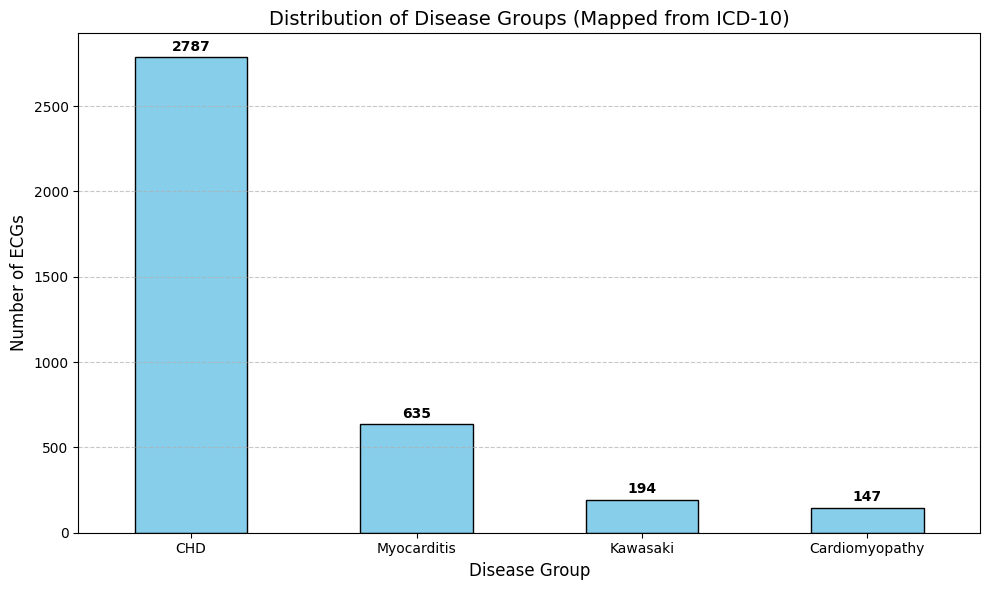

In [16]:
ICD_TO_DISEASE = {
    # Myocarditis
    "(F) I40.0": "Myocarditis",
    "(V) I40.0": "Myocarditis",
    "I40.9": "Myocarditis",
    "I51.4": "Myocarditis",

    # Cardiomyopathy
    "I42.0": "Cardiomyopathy",
    "I42.2": "Cardiomyopathy",
    "I42.9": "Cardiomyopathy",
    "Q24.8": "Cardiomyopathy",

    # Kawasaki disease
    "M30.3": "Kawasaki",

    # Congenital Heart Disease (CHD)
    "Q21.0": "CHD",
    "Q21.1": "CHD",
    "(FO) Q21.1": "CHD",
    "(OSD) Q21.1": "CHD",
    "Q21.2": "CHD",
    "Q21.3": "CHD",
    "Q22.1": "CHD",
    "Q25.0": "CHD",
    "Q25.6": "CHD",
    "I37.0": "CHD"
}

# 2. Load the Attributes Dictionary
# Make sure 'AttributesDictionary.csv' is uploaded to your Colab runtime
df = df_attr

# 3. Helper function to parse and map codes
def get_disease_labels(code_str):
    if pd.isna(code_str):
        return []

    # The codes in the file are formatted like: 'Code1';'Code2'
    # We split by ';' and strip whitespace and the single quotes (')
    raw_codes = [c.strip().strip("'") for c in code_str.split(';')]

    # Find all unique disease groups triggered by these codes
    affected_groups = set()
    for code in raw_codes:
        if code in ICD_TO_DISEASE:
            affected_groups.add(ICD_TO_DISEASE[code])

    return list(affected_groups)

# 4. Apply the mapping
df['Disease_Groups'] = df['ICD-10 code'].apply(get_disease_labels)

# 5. Flatten the list to count total occurrences per group
# If a row has ['Myocarditis', 'CHD'], it counts +1 for both groups.
all_diseases = [disease for sublist in df['Disease_Groups'] for disease in sublist]

# Create a series for easy counting and plotting
counts = pd.Series(all_diseases).value_counts()

# Print the counts for verification
print("Disease Group Counts:")
print(counts)

# 6. Visualize
plt.figure(figsize=(10, 6))
ax = counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Distribution of Disease Groups (Mapped from ICD-10)', fontsize=14)
plt.xlabel('Disease Group', fontsize=12)
plt.ylabel('Number of ECGs', fontsize=12)
plt.xticks(rotation=0)  # Keep labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for i, v in enumerate(counts):
    ax.text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## ICD Code Parsing & Disease Mapping

In [17]:
ICD_TO_DISEASE = {
    # Myocarditis
    "(F) I40.0": "Myocarditis",
    "(V) I40.0": "Myocarditis",
    "I40.0": "Myocarditis",  # <--- ADD THIS to catch cleaned versions
    "I40.9": "Myocarditis",
    "I51.4": "Myocarditis",

    # Cardiomyopathy
    "I42.0": "Cardiomyopathy",
    "I42.2": "Cardiomyopathy",
    "I42.9": "Cardiomyopathy",
    "Q24.8": "Cardiomyopathy",

    # Kawasaki disease
    "M30.3": "Kawasaki",

    # Congenital Heart Disease (CHD)
    "Q21.0": "CHD",
    "Q21.1": "CHD",
    "(FO) Q21.1": "CHD",
    "(OSD) Q21.1": "CHD",
    "Q21.2": "CHD",
    "Q21.3": "CHD",
    "Q22.1": "CHD",
    "Q25.0": "CHD",
    "Q25.6": "CHD",
    "I37.0": "CHD"
}

DISEASE_CLASSES = ['Myocarditis', 'Cardiomyopathy', 'Kawasaki', 'CHD', 'Healthy']
CLASS_IDX = {c: i for i, c in enumerate(DISEASE_CLASSES)}

def parse_icd(s):
    """Parse ICD codes from semicolon-separated string."""
    if pd.isna(s):
        return []
    return [p.strip().replace("'", "") for p in str(s).split(";") if p.strip()]

def clean_icd(code):
    """Clean individual ICD code."""
    if pd.isna(code):
        return None
    code_str = str(code).strip()
    if ')' in code_str:
        code_str = code_str.split(')')[-1].strip()
    return code_str or None

def get_all_diseases(icd_list):
    """
    Get ALL unique diseases from a list of ICD codes.
    Returns list of diseases (e.g., ['Myocarditis', 'CHD']) or ['Healthy'] if none match.
    """
    diseases = set()
    for code in icd_list:
        clean_code = clean_icd(code)
        if clean_code and clean_code in ICD_TO_DISEASE:
            diseases.add(ICD_TO_DISEASE[clean_code])

    if not diseases:
        return ['Healthy']
    return list(diseases)

# Parse ICD codes and get ALL relevant diseases per record
df_attr["ICD_list"] = df_attr["ICD-10 code"].apply(parse_icd)
df_attr["diseases"] = df_attr["ICD_list"].apply(get_all_diseases)
df_attr["n_diseases"] = df_attr["diseases"].apply(len)

# Show statistics
print("Disease distribution (records with each disease):")
disease_counts = {d: 0 for d in DISEASE_CLASSES}
for diseases in df_attr["diseases"]:
    for d in diseases:
        disease_counts[d] += 1
for d, count in disease_counts.items():
    print(f"  {d}: {count}")

# Records with multiple diseases
multi_disease = df_attr[df_attr["n_diseases"] > 1]
print(f"\nRecords with multiple diseases: {len(multi_disease)}")
if len(multi_disease) > 0:
    print("Examples:")
    for _, row in multi_disease.head(5).iterrows():
        print(f"  {row['Filename']}: {row['diseases']}")

Disease distribution (records with each disease):
  Myocarditis: 635
  Cardiomyopathy: 147
  Kawasaki: 194
  CHD: 2787
  Healthy: 10474

Records with multiple diseases: 47
Examples:
  P00/P00310/P00310_E01: ['Cardiomyopathy', 'CHD']
  P00/P00314/P00314_E01: ['Myocarditis', 'CHD']
  P00/P00314/P00314_E02: ['Myocarditis', 'CHD']
  P00/P00314/P00314_E03: ['Myocarditis', 'CHD']
  P00/P00314/P00314_E04: ['Myocarditis', 'CHD']


## Main Processing Pipeline

In [18]:
def process_all_hdf5(df, ecg_dir, max_records=None, target_samples=5000, target_channels=12, output_file=None):
    """
    Process ECG records and save directly to HDF5 (no compression for speed).

    IMPORTANT: Records with multiple diseases are duplicated - each window appears
    once for each applicable disease label to avoid losing multi-disease data.

    Parameters:
    - df: DataFrame with file metadata (must have 'diseases' column with list of diseases)
    - ecg_dir: Directory containing ECG files
    - max_records: Max records to process (None = all)
    - target_samples: Samples per window (default: 5000 = 10s @ 500Hz)
    - target_channels: Number of channels (default: 12)
    - output_file: Path to save HDF5 file (default: OUT_DIR/ecg_data.h5)
    """
    if output_file is None:
        output_file = os.path.join(OUT_DIR, "ecg_data.h5")

    # First pass: count total windows (accounting for multi-disease duplication)
    print("Pass 1: Counting total windows (with multi-disease duplication)...")
    total_windows = 0

    iterator = df.iloc[:max_records].iterrows() if max_records else df.iterrows()
    total_records = max_records if max_records else len(df)

    for idx, row in iterator:
        if (idx + 1) % 500 == 0:
            print(f"  Scanning [{idx + 1}/{total_records}]...")

        fname = row["Filename"]
        diseases = row["diseases"]  # List of diseases
        path = os.path.join(ecg_dir, fname)

        try:
            sig, meta = wfdb.rdsamp(path)
        except:
            continue

        meta_dict = meta if isinstance(meta, dict) else meta.__dict__
        sig = np.asarray(sig)

        # Note: preprocess_record and window_record must be defined as per previous correction
        # (target_fs=500.0, window_sec=10.0)
        sig_proc, fs = preprocess_record(sig, meta_dict, target_fs=500.0)
        windows = window_record(sig_proc, fs, window_sec=10.0, step_sec=10.0, target_samples=target_samples)

        # Each window is duplicated for each disease
        total_windows += len(windows) * len(diseases)

    print(f"\nTotal windows (with duplication): {total_windows}")

    # Second pass: write to HDF5 (no compression for speed)
    print(f"\nPass 2: Writing to HDF5 ({output_file})...")

    with h5py.File(output_file, 'w') as h5f:
        # Create datasets WITHOUT compression for maximum speed
        X_dset = h5f.create_dataset(
            'X',
            shape=(total_windows, target_samples, target_channels),
            dtype=np.float32
        )
        y_dset = h5f.create_dataset(
            'y',
            shape=(total_windows, len(DISEASE_CLASSES)),
            dtype=np.int32
        )
        diseases_dset = h5f.create_dataset(
            'diseases',
            shape=(total_windows,),
            dtype=h5py.string_dtype(encoding='utf-8')
        )
        # Track source filename for each window (useful for debugging)
        source_dset = h5f.create_dataset(
            'source_file',
            shape=(total_windows,),
            dtype=h5py.string_dtype(encoding='utf-8')
        )

        # Store metadata - UPDATED TO REFLECT CORRECT PARAMS
        h5f.attrs['target_samples'] = target_samples
        h5f.attrs['target_channels'] = target_channels
        h5f.attrs['disease_classes'] = DISEASE_CLASSES
        h5f.attrs['sample_rate'] = 500  # Corrected from 100
        h5f.attrs['window_sec'] = 10.0  # Corrected from 5.0
        h5f.attrs['multi_disease_duplication'] = True

        summary_list = []
        window_idx = 0

        iterator = df.iloc[:max_records].iterrows() if max_records else df.iterrows()

        for idx, row in iterator:
            if (idx + 1) % 100 == 0:
                print(f"  [{idx + 1}/{total_records}] {window_idx}/{total_windows} windows written...")

            fname = row["Filename"]
            diseases = row["diseases"]  # List of diseases
            path = os.path.join(ecg_dir, fname)

            try:
                sig, meta = wfdb.rdsamp(path)
            except Exception as e:
                summary_list.append({
                    "Filename": fname,
                    "diseases": diseases,
                    "n_windows": 0,
                    "n_windows_total": 0,
                    "error": str(e)
                })
                continue

            meta_dict = meta if isinstance(meta, dict) else meta.__dict__
            sig = np.asarray(sig)
            original_channels = sig.shape[1]

            # UPDATED: Ensure we call with correct 500Hz / 10s params
            sig_proc, fs = preprocess_record(sig, meta_dict, target_fs=500.0)
            windows = window_record(sig_proc, fs, window_sec=10.0, step_sec=10.0, target_samples=target_samples)

            # For each window, create a copy for EACH disease label
            windows_written = 0
            for window in windows:
                # Pad/truncate channels
                if window.shape[1] < target_channels:
                    pad_channels = target_channels - window.shape[1]
                    window = np.pad(window, ((0, 0), (0, pad_channels)), mode='constant', constant_values=0)
                elif window.shape[1] > target_channels:
                    window = window[:, :target_channels]

                # Write window once for EACH disease
                for disease in diseases:
                    X_dset[window_idx] = window

                    # Create one-hot vector for this specific disease instance
                    # Note: Since we duplicate the window, this vector will have a single '1'
                    label_vec = np.zeros(len(DISEASE_CLASSES), dtype=np.int32)
                    label_vec[CLASS_IDX[disease]] = 1
                    y_dset[window_idx] = label_vec

                    diseases_dset[window_idx] = disease
                    source_dset[window_idx] = fname
                    window_idx += 1
                    windows_written += 1

            summary_list.append({
                "Filename": fname,
                "diseases": str(diseases),
                "n_diseases": len(diseases),
                "n_windows_raw": len(windows),
                "n_windows_total": windows_written,
                "original_channels": original_channels
            })

    print(f"\nSaved to {output_file}")
    print(f"  X shape: ({window_idx}, {target_samples}, {target_channels})")
    print(f"  Data format: float32, no compression")
    print(f"  Multi-disease duplication: enabled")

    return output_file, pd.DataFrame(summary_list)

# Run processing - UPDATED PRINT STATEMENT
print("Processing ECG records (10s windows @ 500Hz, no overlap, multi-disease duplication)...")
# Note: Ensure df_attr and ECG_DIR are defined in your environment
h5_file, df_summary = process_all_hdf5(df_attr, ECG_DIR, max_records=None, target_samples=5000)

# Verify file
with h5py.File(h5_file, 'r') as h5f:
    print(f"\nDataset shapes:")
    print(f"  X: {h5f['X'].shape} (dtype: {h5f['X'].dtype})")
    print(f"  y: {h5f['y'].shape}")
    print(f"  diseases: {h5f['diseases'].shape}")

    print(f"\nDisease distribution (window count):")
    for i, cls in enumerate(DISEASE_CLASSES):
        # We need to slice all rows to sum properly
        count = np.sum(h5f['y'][:, i])
        print(f"  {cls}: {count}")

Processing ECG records (10s windows @ 500Hz, no overlap, multi-disease duplication)...
Pass 1: Counting total windows (with multi-disease duplication)...
  Scanning [500/14190]...
  Scanning [1000/14190]...
  Scanning [1500/14190]...
  Scanning [2000/14190]...
  Scanning [2500/14190]...
  Scanning [3000/14190]...
  Scanning [3500/14190]...
  Scanning [4000/14190]...
  Scanning [4500/14190]...
  Scanning [5000/14190]...
  Scanning [5500/14190]...
  Scanning [6000/14190]...
  Scanning [6500/14190]...
  Scanning [7000/14190]...
  Scanning [7500/14190]...
  Scanning [8000/14190]...
  Scanning [8500/14190]...
  Scanning [9000/14190]...
  Scanning [9500/14190]...
  Scanning [10000/14190]...
  Scanning [10500/14190]...
  Scanning [11000/14190]...
  Scanning [11500/14190]...
  Scanning [12000/14190]...
  Scanning [12500/14190]...
  Scanning [13000/14190]...
  Scanning [13500/14190]...
  Scanning [14000/14190]...

Total windows (with duplication): 37285

Pass 2: Writing to HDF5 (/content/ECG-da

## Save Results

In [19]:
# Save processing summary and metadata
df_summary.to_csv(os.path.join(OUT_DIR, "processing_summary.csv"), index=False)

with open(os.path.join(OUT_DIR, "disease_classes.json"), "w") as f:
    json.dump({
        "classes": DISEASE_CLASSES,
        "class_idx": CLASS_IDX,
        "icd_map": ICD_TO_DISEASE,
        "data_format": "hdf5",
        "hdf5_file": "ecg_data.h5",
        "sample_rate": 500,        # Corrected from 100
        "window_sec": 10.0,        # Corrected from 5.0
        "target_samples": 5000,    # Corrected from 500
        "target_channels": 12,
        "multi_disease_duplication": True
    }, f, indent=2)

# Summary statistics
print(f"Saved to {OUT_DIR}")
print(f"  - ecg_data.h5 (HDF5 format, no compression)")
print(f"  - processing_summary.csv")
print(f"  - disease_classes.json")

print(f"\nProcessing summary:")
if not df_summary.empty:
    print(f"  Total records processed: {len(df_summary)}")
    print(f"  Records with multiple diseases: {(df_summary['n_diseases'] > 1).sum()}")
    print(f"  Total raw windows: {df_summary['n_windows_raw'].sum()}")
    print(f"  Total windows after duplication: {df_summary['n_windows_total'].sum()}")
else:
    print("  No records processed successfully.")

Saved to /content/ECG-database/artifacts/multilabel_v6
  - ecg_data.h5 (HDF5 format, no compression)
  - processing_summary.csv
  - disease_classes.json

Processing summary:
  Total records processed: 14190
  Records with multiple diseases: 47
  Total raw windows: 37152
  Total windows after duplication: 37285


## Upload to Hugging Face (Optional)

In [21]:
UPLOAD_TO_HF = True  # Set to True to upload
from google.colab import userdata
if UPLOAD_TO_HF:
    from huggingface_hub import HfApi, login

    print("Logging into Hugging Face...")
    login(userdata.get('HF'))

    api = HfApi()
    print("Uploading to HF...")
    api.upload_folder(
        folder_path='/content/ECG-database/artifacts/multilabel_v6',
        repo_id="kiril-buga/ECG-database",
        repo_type="dataset",
        path_in_repo="multilabel_v7",
        commit_message="Multi-label preprocessed data"
    )
    print("✓ Uploaded to HF")
else:
    print("To upload: set UPLOAD_TO_HF=True and have HF write token")

Logging into Hugging Face...
Uploading to HF...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...multilabel_v6/ecg_data.h5:   0%|          |  609kB / 8.95GB            

✓ Uploaded to HF
